# Baseband signal upconversion and IQ Modulation and Demodulation
- https://dspillustrations.com/pages/posts/misc/baseband-up-and-downconversion-and-iq-modulation.html  
- https://dspillustrations.com/pages/pages/courses/course_singlecarrier/Welcome_HandsOnDigitalCommunications.html

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', 'Waves', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from waves.sound import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings 

warnings.filterwarnings('ignore')

In [6]:
def show_pair(sig_left, sig_right, frames = 300):
    sig_left.show(color = 'red', show_frames = slice(0, frames))
    sig_right.show(color = 'green', show_frames = slice(0, frames))

## LO

In this article, we will go through the basic steps of the up- and downconversion of a baseband signal to the passband signal. In most digital signal processing devices, any signal processing is performed in the baseband, i.e. where the signals are centered around the DC frequency. These baseband signals are mainly complex-valued. However, only real-valued signals can be sent with real-world physical devices. The process of upconversion thus has two purposes:

- Convert the complex-valued baseband signal to a real-valued signal which can be transmitted over an antenna, cable or similar.
- Adapt the transmit signal such that it uses a specific frequency band of the physical channel. This way, multiple signals can be transmitted independently on different frequency bands.  

At the receiver, the received signal is then downconverted to baseband such that the subsequent processing can be done in complex-valued baseband domain.

A generic digital transceiver system with digital baseband processing, analog to digital conversion and up- and downconversion is presented in the figure below:

![](qm.png)


In the following steps, we will go through the components and numerically illustrate, what happens within these blocks. Let us first define some variables and constants:

In [7]:
Fs = int(6e4)    # the sampling frequency we use for the discrete simulation of analog signals

fc = int(3e3)    # 3kHz carrier frequency
Ts = 1e-3        # 1 ms symbol spacing, i.e. the baseband samples are Ts seconds apart.
BN = 1/(2*Ts )   # the Nyquist bandwidth of the baseband signal.


ups = int(Ts*Fs) # number of samples per symbol in the "analog" domain
N = 10           # number of transmitted baseband samples

In [8]:
import numpy as np



def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.
    Parameters
    ----------
    N : int
        Length of the filter in samples.
    alpha : float
        Roll off factor (Valid values are [0, 1]).
    Ts : float
        Symbol period in seconds.
    Fs : float
        Sampling Rate in Hz.
    Returns
    ---------
    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1 / float(Fs)
    time_idx = ((np.arange(N) - N / 2)) * T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype = float)

    for x in sample_num:
        t = (x - N / 2) * T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4 * alpha / np.pi)
        elif alpha != 0 and t == Ts / (4 * alpha):
            h_rrc[x] = (alpha / np.sqrt(2)) * (((1 + 2 / np.pi) * \
                                                (np.sin(np.pi / (4 * alpha)))) + (
                                                       (1 - 2 / np.pi) * (np.cos(np.pi / (4 * alpha)))))
        elif alpha != 0 and t == -Ts / (4 * alpha):
            h_rrc[x] = (alpha / np.sqrt(2)) * (((1 + 2 / np.pi) * \
                                                (np.sin(np.pi / (4 * alpha)))) + (
                                                       (1 - 2 / np.pi) * (np.cos(np.pi / (4 * alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi * t * (1 - alpha) / Ts) + \
                        4 * alpha * (t / Ts) * np.cos(np.pi * t * (1 + alpha) / Ts)) / \
                       (np.pi * t * (1 - (4 * alpha * t / Ts) * (4 * alpha * t / Ts)) / Ts)

    return time_idx, h_rrc

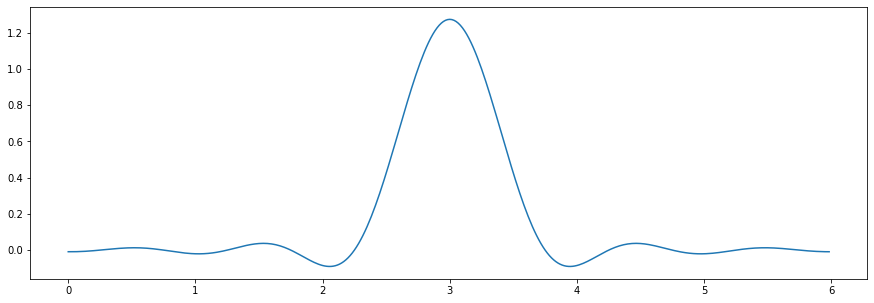

In [9]:
# Hence, it introduces a delay of 3Ts seconds.
t0 = 3*Ts  


# Calculate the filter coefficients (N=number of samples in filter)
plt.figure(figsize = (15, 5))
_, rrc = rrcosfilter(N=int(2*t0*Fs), alpha=1,Ts=Ts, Fs=Fs)
t_rrc = np.arange(len(rrc)) / Fs  # the time points that correspond to the filter values
plt.plot(t_rrc/Ts, rrc);

In [10]:
# Step T1)

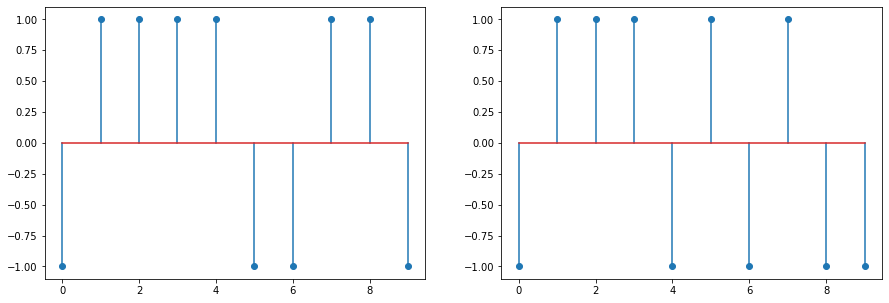

In [11]:
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j])  # the possible values in the baseband
dk = np.random.choice(constellation, size=(N))        # randomly choose some samples
t_symbols = Ts * np.arange(N)                         # time instants of the baseband samples

# Plot the samples 
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(t_symbols/Ts, dk.real);
plt.subplot(122)
plt.stem(t_symbols/Ts, dk.imag);

In [12]:
# Step T2)

<Figure size 1080x360 with 0 Axes>

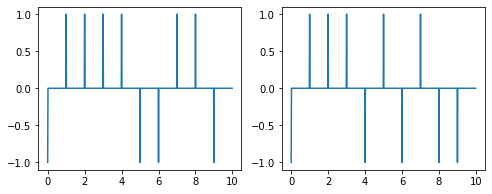

In [13]:
x = np.zeros(ups*N, dtype='complex')
x[::ups] = dk  # every ups samples, the value of dn is inserted into the sequence
t_x = np.arange(len(x))/Fs

plt.figure(figsize = (15, 5))
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t_x/Ts, x.real);
plt.subplot(122)
plt.plot(t_x/Ts, x.imag);

In [14]:
# Step T3)

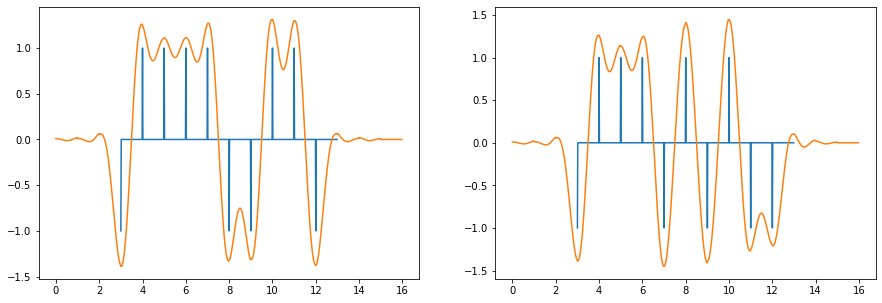

In [15]:
u = np.convolve(x, rrc)

t_u = np.arange(len(u))/Fs

plt.figure(figsize = (15, 5))
plt.subplot(121)  
plt.plot((t_x+t0)/Ts, x.real, label='$x(t)$') # artificial extra delay for the baseband samples
plt.plot(t_u/Ts, u.real, label='$u(t)$')
plt.subplot(122)
plt.plot((t_x+t0)/Ts, x.imag)
plt.plot(t_u/Ts, u.imag);

In [16]:
# Step T4)

In [17]:
i = u.real
q = u.imag

In [18]:
# Step T5)

In [19]:
iup = i * np.cos(2*np.pi*t_u*fc)  
qup = q * -np.sin(2*np.pi*t_u*fc)

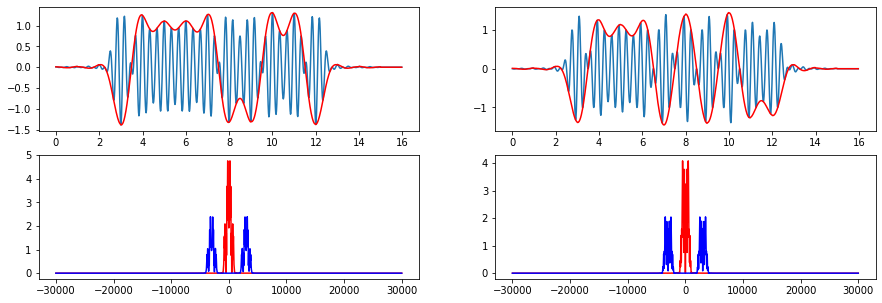

In [20]:
# define a function to calculate the spectrum of a signal
fftLen = 4*len(u)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / Fs * (len(u))

# Calculate the spectrum of the signals
f_u = np.linspace(-Fs/2, Fs/2, fftLen)
I = spectrum(i); Iup = spectrum(iup)
Q = spectrum(q); Qup = spectrum(qup)

# Plot the time-domain signals
plt.figure(figsize = (15, 5))
plt.subplot(221)
plt.plot(t_u/Ts, iup, label='$i_{up}(t)$')
plt.plot(t_u/Ts, i, 'r', label='$i(t)$')

plt.subplot(222)
plt.plot(t_u/Ts, qup, label='$q_{up}(t)$')
plt.plot(t_u/Ts, q, 'r', label='$q(t)$')

plt.subplot(223)
plt.plot(f_u, abs(I), 'r')
plt.plot(f_u, abs(Iup), 'b')

plt.subplot(224)
plt.plot(f_u, abs(Q), 'r')
plt.plot(f_u, abs(Qup), 'b');

In [21]:
# Step T6)

In [22]:
s = iup + qup

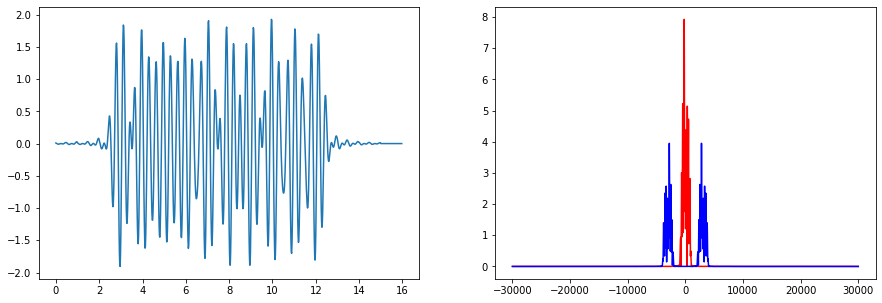

In [23]:
S = spectrum(s)
U = spectrum(u)

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(t_u/Ts, s)

plt.subplot(122)
plt.plot(f_u, abs(U), 'r', label='$|U(f)|$')
plt.plot(f_u, abs(S), 'b', label='$|S(f)|$');

## The Receiver (Steps R1-R5)
At the receiver, in step R1) the signal s(t) is first multiplied by a sine and a cosine to get a down-converted I and Q component, given by
idown(t)qdown(t)=s(t)cos(2πfct)=−s(t)sin(2πfct)(3)(4).

In [24]:
# Step R1)

In [25]:
idown = s * np.cos(2*np.pi*-fc*t_u) 
qdown = s * -np.sin(2*np.pi*fc*t_u)

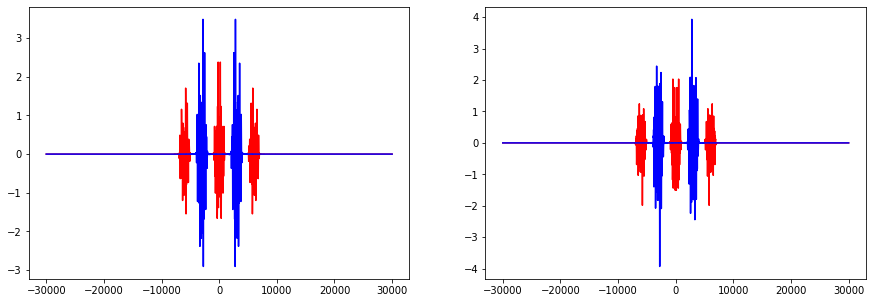

In [26]:
Idown = spectrum(idown)
Qdown = spectrum(qdown)

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(f_u, Idown.real, label=r'$\Re\{I_(f)\}$', color='r')
plt.plot(f_u, S.real, label='$\Re\{S(f)\}$', color='b')

plt.subplot(122)
plt.plot(f_u, Qdown.real, label=r'$\Re\{Q_(f)\}$', color='r')
plt.plot(f_u, S.imag, label=r'$\Im\{S(f)\}$', color='b');

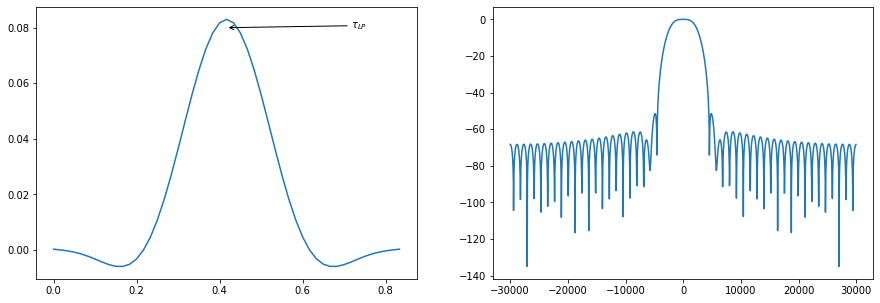

In [27]:
import scipy

cutoff = 5*BN        # arbitrary design parameters
lowpass_order = 51   
lowpass_delay = (lowpass_order // 2)/Fs  # a lowpass of order N delays the signal by N/2 samples (see plot)
# design the filter
lowpass = scipy.signal.firwin(lowpass_order, cutoff/(Fs/2))

# calculate frequency response of filter
t_lp = np.arange(len(lowpass))/Fs
f_lp = np.linspace(-Fs/2, Fs/2, 2048, endpoint=False)
H = np.fft.fftshift(np.fft.fft(lowpass, 2048))

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(t_lp/Ts, lowpass)
plt.gca().annotate(r'$\tau_{LP}$', xy=(lowpass_delay/Ts,0.08), xytext=(lowpass_delay/Ts+0.3, 0.08), arrowprops=dict(arrowstyle='->'))

plt.subplot(122)
plt.plot(f_lp, 20*np.log10(abs(H)));

In [28]:
# Step R2) 

In [29]:
idown_lp = scipy.signal.lfilter(lowpass, 1, idown)
qdown_lp = scipy.signal.lfilter(lowpass, 1, qdown)

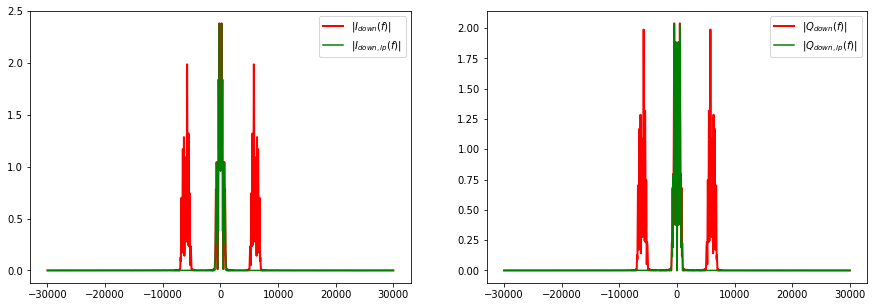

In [30]:
Idown_lp = spectrum(idown_lp)
Qdown_lp = spectrum(qdown_lp)

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(f_u, abs(Idown), 'r', lw=2, label=r'$|I_{down}(f)|$')
plt.plot(f_u, abs(Idown_lp), 'g-', label=r'$|I_{down,lp}(f)|$')
plt.legend();

plt.subplot(122)
plt.plot(f_u, abs(Qdown), 'r', lw=2, label=r'$|Q_{down}(f)|$')
plt.plot(f_u, abs(Qdown_lp), 'g', label=r'$|Q_{down,lp}(f)|$')
plt.legend();

In [31]:
# Step R3)

In [32]:
v = idown_lp + 1j*qdown_lp

In [33]:
# Step R4)

In [34]:
y = np.convolve(v, rrc) / (sum(rrc**2)) * 2

In [35]:
# Step R5)

In [36]:
delay = int((2*t0 + lowpass_delay)*Fs)

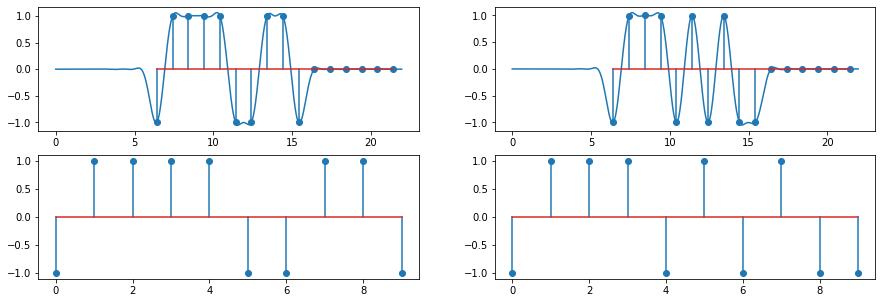

In [37]:
t_y = np.arange(len(y))/Fs
t_samples = t_y[delay::ups]
y_samples = y[delay::ups]

plt.figure(figsize = (15, 5))
plt.subplot(221)
plt.plot(t_y/Ts, y.real)
plt.stem(t_samples/Ts, y_samples.real)

plt.subplot(222)
plt.plot(t_y/Ts, y.imag)
plt.stem(t_samples/Ts, y_samples.imag)

plt.subplot(223)
plt.stem(t_symbols/Ts, dk.real);
plt.subplot(224)
plt.stem(t_symbols/Ts, dk.imag);

#### As shown, the received samples match the transmitted samples, however a significant delay due to the intermediate filters was introduced.

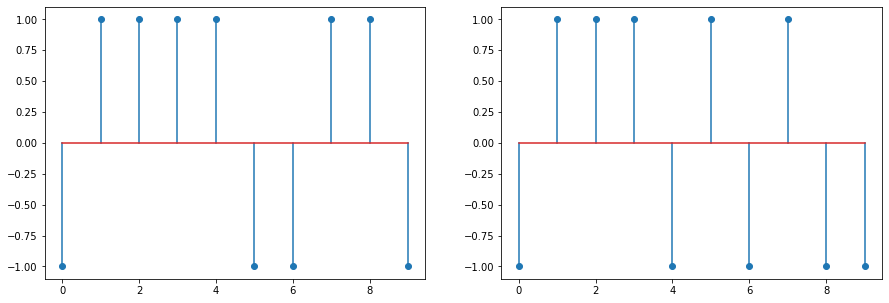

In [38]:
# Plot the samples 
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(t_symbols/Ts, dk.real);
plt.subplot(122)
plt.stem(t_symbols/Ts, dk.imag);